# функции и импорт библиотек

In [1]:
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import glob
import cv2
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.utils import to_categorical
from sklearn.metrics import average_precision_score
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             precision_recall_fscore_support,
                             classification_report, precision_recall_curve)
%matplotlib inline



def ReadData(path_data):
    imagePaths = [file for file in glob.glob(path_data + "*")]
    data, labels = [], []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (96, 86))
        data.append(image)
        
    data = np.array(data)
    return data



def DivideData():
    
    # train data path
    train_path_data =  './bodies/dataset/train/'
    train_path_data_neg = train_path_data + 'neg/'
    train_path_data_pos = train_path_data + 'pos/'

    train_data_neg = ReadData(train_path_data_neg)
    train_data_pos = ReadData(train_path_data_pos)
    
    
    # test data path
    test_path_data =  './bodies/dataset/testing_set_people/'
    test_path_data_neg = test_path_data + 'neg/'
    test_path_data_pos = test_path_data + 'pos/'

    test_data_neg = ReadData(test_path_data_neg)
    test_data_pos = ReadData(test_path_data_pos)
    
    # get X_train, X_test
    X_train = np.concatenate([train_data_pos, train_data_neg])
    X_test = np.concatenate([test_data_pos, test_data_neg])
    
    # get y_train, y_test
    y_train = np.concatenate([np.ones(train_data_pos.shape[0]),np.zeros(train_data_neg.shape[0])])
    y_test = np.concatenate([np.ones(test_data_pos.shape[0]),np.zeros(test_data_neg.shape[0])])
    
    return (X_train, X_test, 
            y_train, y_test)


def CannyEdge(images):
    
    data_canny = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(image,100,200)
        image = cv2.resize(image, (96, 86))
        data_canny.append(image)

    data_canny = np.array(data_canny)
    return data_canny


def mtcnn_classifier(image, detector):
    """ MTCNN FACE DETECTION PRETRAINED """
    
    bounding_boxes = detector.detect_faces(image)
    if len(bounding_boxes) > 0:
        return 1
    else:
        return 0
    
def classify_MTCNN_AllData(images):
    """ classify all data via MTCNN classifier """
    detector = MTCNN()
    classified_data = [mtcnn_classifier(img, detector) for img in images]
    return classified_data



haar_cascade_face = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
haar_cascade_upper_body = cv2.CascadeClassifier('./haarcascade_upperbody.xml')

def haarclassifier(images, haar_cascade_face, haar_cascade_upper_body):
    """ classify all data via HAAR CASCADE classifier for upper body and frontal face """

    haar_features = []
    for img in images:
        faces_rects = haar_cascade_face.detectMultiScale(img, scaleFactor = 1.2, minNeighbors = 5)
        upper_body_rects = haar_cascade_upper_body.detectMultiScale(img, scaleFactor = 1.2, minNeighbors = 5)
        haar_features.append([len(faces_rects), len(upper_body_rects), len(faces_rects) + len(upper_body_rects)])
        
    return haar_features



def plot_results(history):
    """
    результаты Accuracy на тренировочных и валидационных данных на разных эпохах
    """
    import seaborn as sns
    from matplotlib import rcParams
    sns.set_style("whitegrid")
    rcParams['figure.figsize'] = 20,10
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy на тренировочных и валидационных данных ', fontsize=15)

    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')


def pr_recall_curve(y_test, predictions):
    
    """ 
    precicion recall curve
    """
    average_precision = average_precision_score([int(x) for x in y_test[:,1].tolist()], predictions[:,1].tolist())
    precision, recall, _ = precision_recall_curve([int(x) for x in y_test[:,1].tolist()], predictions[:,1].tolist())


    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    print(average_precision)

# считывание данных и разделение на тест-трэйн

In [2]:
# train test split
(X_train, X_test, y_train, y_test) = DivideData()

#normalize data
X_train = X_train.astype('float')
X_test = X_test.astype('float')
X_train /= 255
X_test/= 255

In [3]:

# равномерное распределение по классам
train_size = [int(x) for x in y_train.tolist()]
test_size = [int(x) for x in y_test.tolist()]

print('******************************')
print("количество единичек на трейн части : {}".format(sum(train_size)))
print("количество нулей на трейн части : {}".format(len(train_size) - sum(train_size)))
print('******************************')

print("количество единичек на тест части : {}".format(sum(test_size)))
print("количество нулей на test части : {}".format(len(test_size) - sum(test_size)))
print('******************************')

******************************
количество единичек на трейн части : 8122
количество нулей на трейн части : 8998
******************************
количество единичек на тест части : 556
количество нулей на test части : 532
******************************


In [4]:
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# KERAS MODEL

In [5]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(86, 96, 3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(16, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(8, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, shuffle=True)

Epoch 1/20
535/535 [==============================] - 235s 439ms/step - loss: 0.3805 - accuracy: 0.8216 - val_loss: 0.6709 - val_accuracy: 0.6553
Epoch 2/20
535/535 [==============================] - 236s 442ms/step - loss: 0.2193 - accuracy: 0.9127 - val_loss: 0.7199 - val_accuracy: 0.6186
Epoch 3/20
535/535 [==============================] - 237s 442ms/step - loss: 0.1804 - accuracy: 0.9307 - val_loss: 0.5612 - val_accuracy: 0.7583
Epoch 4/20
535/535 [==============================] - 234s 437ms/step - loss: 0.1485 - accuracy: 0.9451 - val_loss: 0.8980 - val_accuracy: 0.6259
Epoch 5/20
535/535 [==============================] - 236s 441ms/step - loss: 0.1461 - accuracy: 0.9454 - val_loss: 0.6168 - val_accuracy: 0.7270
Epoch 6/20
535/535 [==============================] - 234s 437ms/step - loss: 0.1176 - accuracy: 0.9572 - val_loss: 0.4991 - val_accuracy: 0.7904
Epoch 7/20
535/535 [==============================] - 233s 436ms/step - loss: 0.0977 - accuracy: 0.9641 - val_loss: 0.8851 -

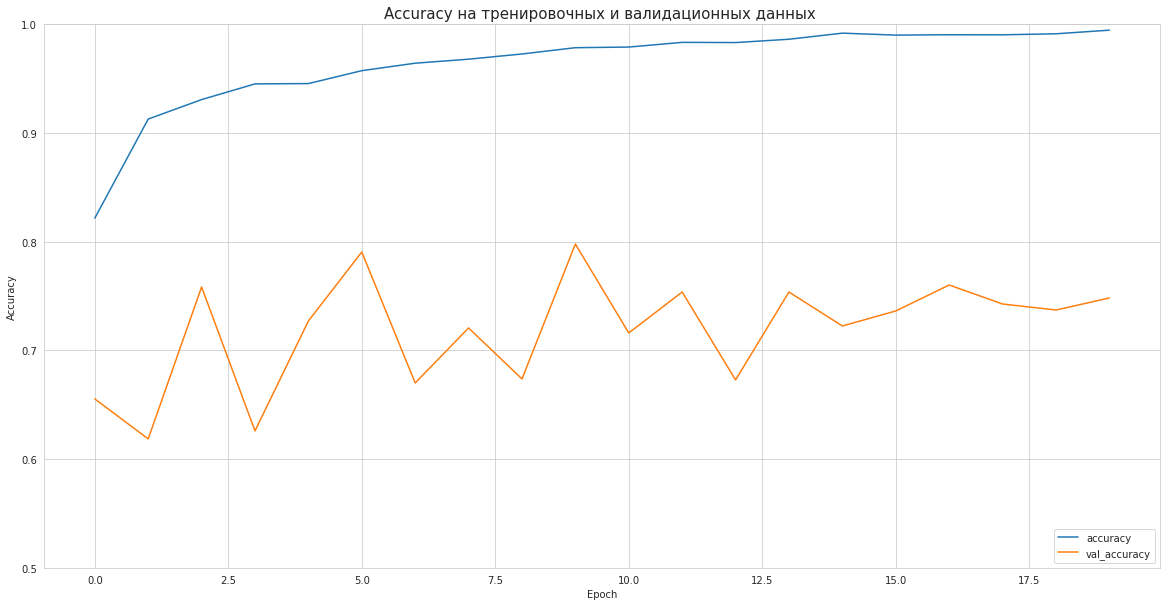

In [17]:
plot_results(history)

In [46]:
# итоговый резльтат accuracy на валидационном сете
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

34/34 - 3s - loss: 1.3362 - accuracy: 0.7482


In [47]:
# архитектура нейронной сети
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 84, 94, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 92, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 44, 16)        4624      
_________________________________________________________________
dropout (Dropout)            (None, 39, 44, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 42, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 10, 8)          0

0.8363298751691011


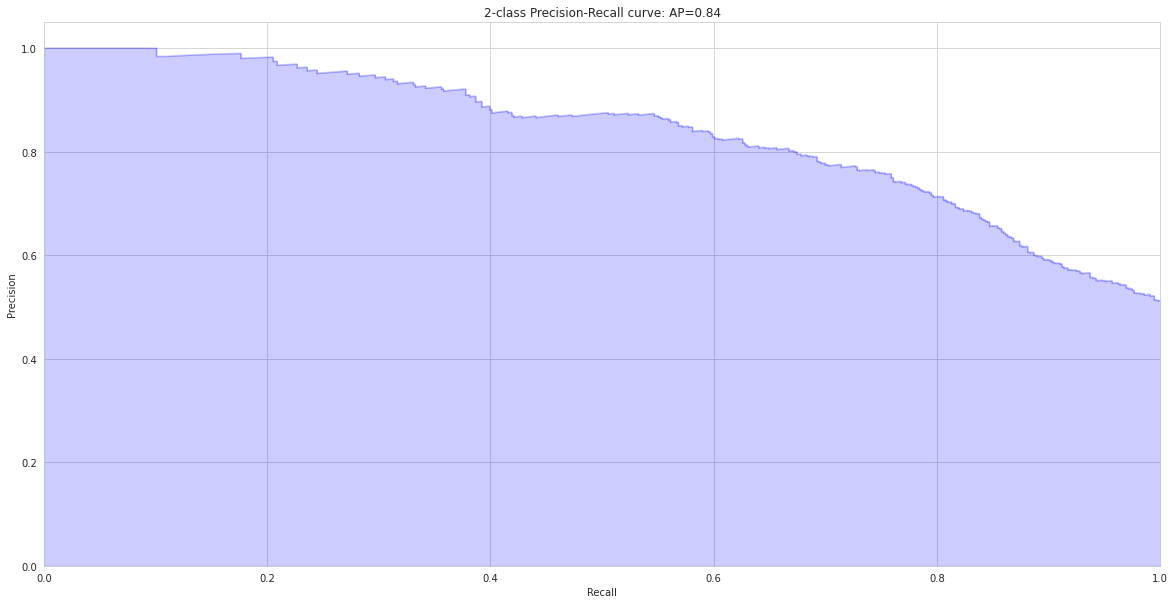

In [45]:
pr_recall_curve(y_test, predictions)

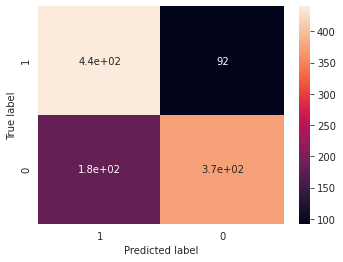

In [58]:
import pandas as pd
import seaborn as sns
# Creates a confusion matrix
cm = confusion_matrix([int(x) for x in y_test[:,1].tolist()], np.argmax(predictions, axis= 1)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1','0'], 
                     columns = ['1','0'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [61]:
print(classification_report([int(x) for x in y_test[:,1].tolist()], np.argmax(predictions, axis= 1)))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76       532
           1       0.80      0.67      0.73       556

    accuracy                           0.75      1088
   macro avg       0.75      0.75      0.75      1088
weighted avg       0.76      0.75      0.75      1088



In [62]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# MTCNN

In [66]:
# train test split
(X_train, X_test, y_train, y_test) = DivideData()

In [67]:
# предикт MTCNN
y_predicted = classify_MTCNN_AllData(X_test)

In [70]:
from sklearn.metrics import accuracy_score
y_true = y_test.tolist()
accuracy_score(y_true, y_predicted)

0.8722426470588235

In [71]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88       532
         1.0       1.00      0.75      0.86       556

    accuracy                           0.87      1088
   macro avg       0.90      0.88      0.87      1088
weighted avg       0.90      0.87      0.87      1088



# HAAR CASCADE CLASSIFIER

In [88]:
# вызываем предикт HAAR CASCADE classifier для определения 
# 1) фронтальная часть лица
# 2) верхняя часть туловища
# 3) фронтальная часть лица или верхняя часть туловища

haarclassifier_predict = haarclassifier(X_test, haar_cascade_face, haar_cascade_upper_body)


y_predicted_frontal_face = [1 if x>0 else 0 for x in np.array(haarclassifier_predict)[:,0].tolist()]
y_predicted_upper_body = [1 if x>0 else 0 for x in np.array(haarclassifier_predict)[:,1].tolist()]
y_predicted_sum = [1 if x>0 else 0 for x in np.array(haarclassifier_predict)[:,2].tolist()]

In [89]:
#frontal face
accuracy_score(y_true, y_predicted_frontal_face)

0.5670955882352942

In [91]:
print(classification_report(y_true, y_predicted_frontal_face))

              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69       532
         1.0       1.00      0.15      0.27       556

    accuracy                           0.57      1088
   macro avg       0.77      0.58      0.48      1088
weighted avg       0.77      0.57      0.47      1088



In [92]:
#upper_body
accuracy_score(y_true, y_predicted_upper_body)

0.49080882352941174

In [93]:
print(classification_report(y_true, y_predicted_upper_body))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       532
         1.0       1.00      0.00      0.01       556

    accuracy                           0.49      1088
   macro avg       0.74      0.50      0.33      1088
weighted avg       0.75      0.49      0.33      1088



In [94]:
#upper_body + frontal face
accuracy_score(y_true, y_predicted_sum)

0.5689338235294118

In [95]:
print(classification_report(y_true, y_predicted_sum))

              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69       532
         1.0       1.00      0.16      0.27       556

    accuracy                           0.57      1088
   macro avg       0.77      0.58      0.48      1088
weighted avg       0.77      0.57      0.48      1088



# попробуем найти лица с помощью лучшей модели

In [141]:
# settings
rcParams['figure.figsize'] = 10, 10
sns.set_style("whitegrid", {'axes.grid' : False})

# train test data
(X_train, X_test, y_train, y_test) = DivideData()

def plot_img(img):
    plt.imshow(img)
    
def bound_box_plot(img):
    
    detector = MTCNN()
    bounding_boxes = detector.detect_faces(img)
    if len(bounding_boxes) > 0:

        bounding_box=bounding_boxes[0]['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,100,255),1)
        plt.imshow(x)
        
    else:
        plt.imshow(img)

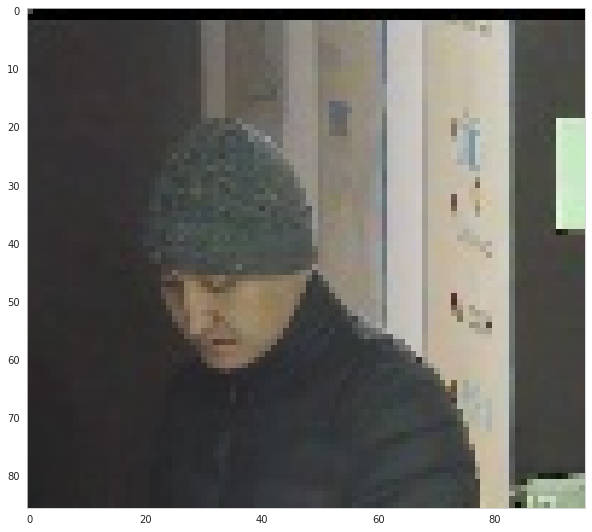

In [142]:
# исходное изображение
plot_img(X_test[0])

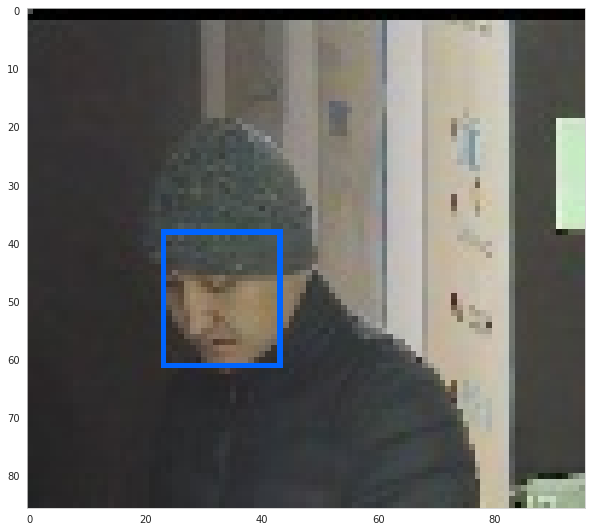

In [143]:
# детектируем лицо
bound_box_plot(X_test[0])

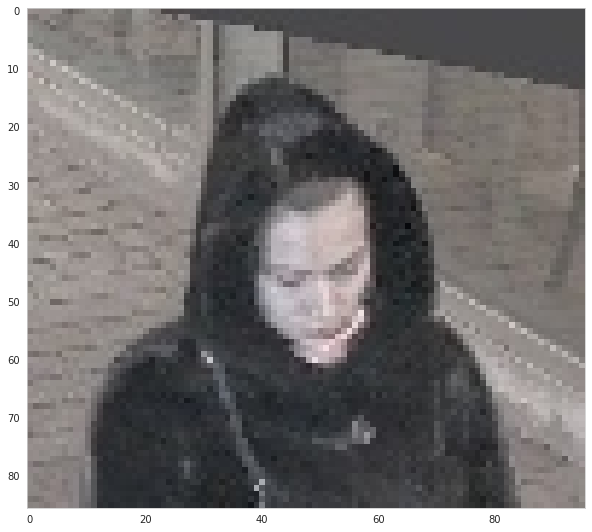

In [144]:
# исходное изображение
plot_img(X_test[1])

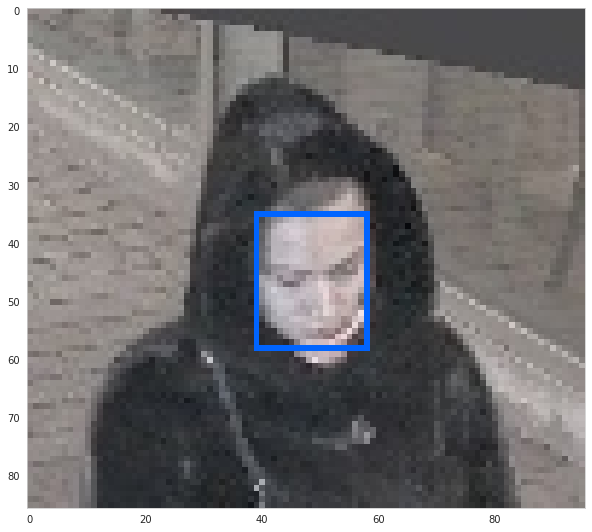

In [145]:
# детектируем лицо
bound_box_plot(X_test[1])

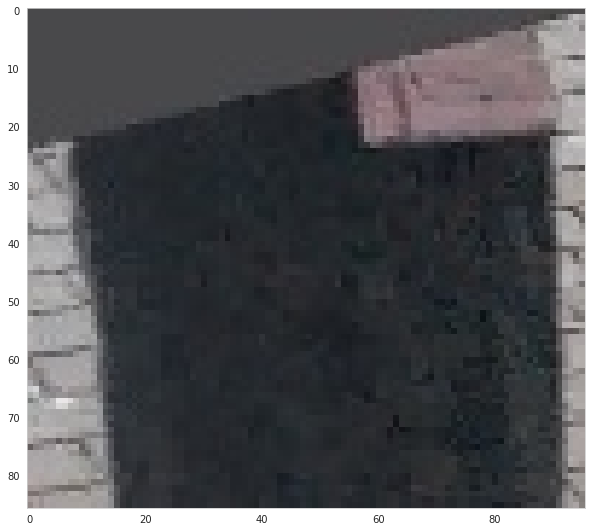

In [146]:
# исходное изображение
plot_img(X_test[-1])

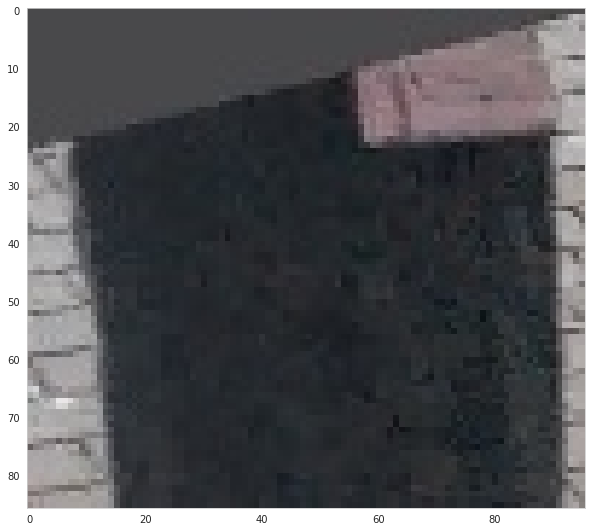

In [147]:
# детектируем лицо
bound_box_plot(X_test[-1])